In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/noise2noise

Mounted at /content/drive
/content/drive/MyDrive/noise2noise


In [ ]:
! git config --global user.email "erwan.serandour@epfl.ch"
! git config --global user.name "thurgarion2"

In [ ]:
!git add .
!git commit -m 'compare unet normal with unet batchnorm'

[master 6c7e1a1] compare unet normal with unet batchnorm


In [ ]:
! git pull

error: You have not concluded your merge (MERGE_HEAD exists).
hint: Please, commit your changes before merging.
fatal: Exiting because of unfinished merge.


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
!pip3 install -e . -q
!pip3 install nbdev -q

In [ ]:
!nbdev_build_lib

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


Converted 00_baseline.ipynb.
Converted 00_helpers.ipynb.
Converted 00_training.ipynb.
Converted 00_unet.ipynb.
Converted index.ipynb.


In [8]:
from noise2noise.training import *
from noise2noise.unet import *
from noise2noise.helpers import *
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training_img, training_target = load_images()
mean, std = to_float_image(training_img).mean(dim=(0,2,3)), to_float_image(training_img).std(dim=(0,2,3))
input_transform = transforms.Compose([ToFloatImage(), transforms.Normalize(mean =mean, std = std)])

target_transform = transforms.Compose([ToFloatImage()])

In [6]:
train_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 64,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

test_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 64,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)


 10%|█         | 100/1000 [00:10<01:32,  9.77it/s]Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
100%|██████████| 1000/1000 [01:43<00:00,  9.66it/s]


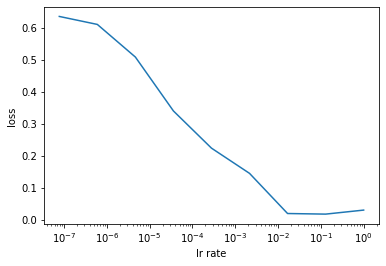

In [ ]:
unet = UnetBatchNorm().to(device)
metric = psnr_metric()
criterion = nn.MSELoss()

lr_finder(unet, train_loader, Adam, criterion, gradient_steps=1000, samples_steps=100)

In [11]:
unet = UnetBatchNorm().to(device)
optim = Adam(unet.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.975)

metric = psnr_metric()
criterion = nn.MSELoss()




train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=100)

100%|██████████| 2000/2000 [03:53<00:00,  8.57it/s]


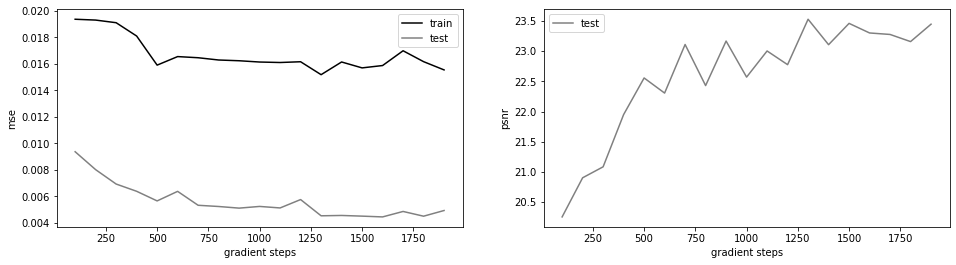

In [14]:
plot_losses(train_loss, test_loss, test_metric)

psnr :27.416423797607422
psnr :20.860366821289062
psnr :21.731643676757812
psnr :27.644433975219727


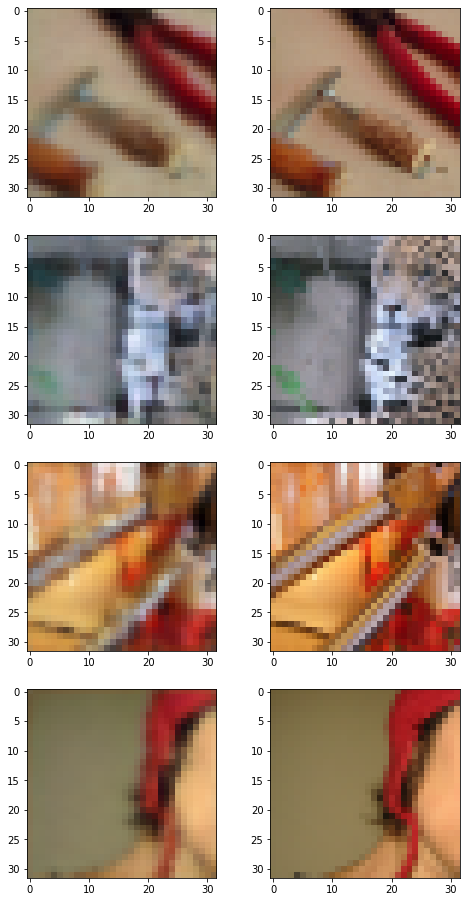

In [13]:
show_results(unet, test_loader)

In [15]:
unet = UnetBatchNorm().to(device)
optim = Adam(unet.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.975)

metric = psnr_metric()
criterion = nn.MSELoss()




train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=4000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=100)

100%|██████████| 4000/4000 [07:43<00:00,  8.62it/s]


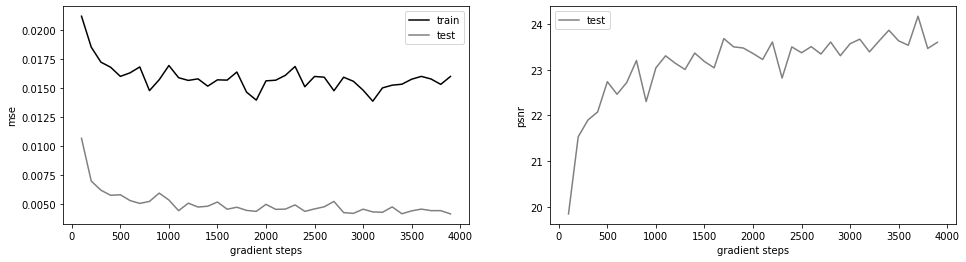

In [16]:
plot_losses(train_loss, test_loss, test_metric)

psnr :24.156570434570312
psnr :25.732807159423828
psnr :26.894941329956055
psnr :22.40279197692871


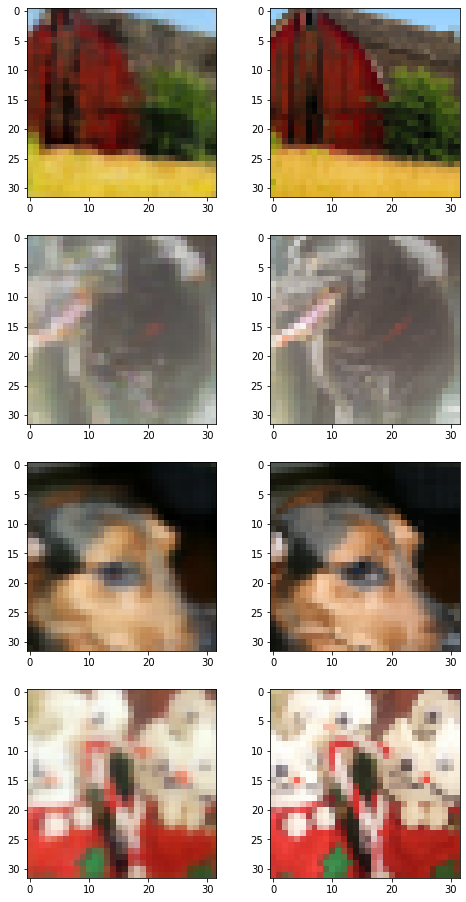

In [20]:
show_results(unet, test_loader)